# A model to predict Confused student EEG brainwave data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# list all files under the input directory
import os
for dirname, _, filenames in os.walk('./drive/MyDrive/Colab Notebooks/confused-eeg'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Data Preparation

In [3]:
# Reading the datasets
eeg_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/confused-eeg/EEG_data.csv")
demographic_info = pd.read_csv("./drive/MyDrive/Colab Notebooks/confused-eeg/demographic_info.csv")

In [4]:
# Merging the datasets on Subject ID
demographic_info = demographic_info.rename(columns = {'subject ID': 'SubjectID',' gender':'gender',' age':'age',' ethnicity':'ethnicity'})
input_df = eeg_data.merge(demographic_info,how = 'inner',on = 'SubjectID')
input_df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln,age,ethnicity,gender
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0,25,Han Chinese,M
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0,25,Han Chinese,M
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0,25,Han Chinese,M
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0,25,Han Chinese,M
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0,25,Han Chinese,M


## Exploring the dataset
To reach the optimized solution

In [7]:
# see df's shape
input_df.shape

(12811, 18)

In [8]:
# see if there's any missing columns
input_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12811 entries, 0 to 12810
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SubjectID           12811 non-null  float64
 1   VideoID             12811 non-null  float64
 2   Attention           12811 non-null  float64
 3   Mediation           12811 non-null  float64
 4   Raw                 12811 non-null  float64
 5   Delta               12811 non-null  float64
 6   Theta               12811 non-null  float64
 7   Alpha1              12811 non-null  float64
 8   Alpha2              12811 non-null  float64
 9   Beta1               12811 non-null  float64
 10  Beta2               12811 non-null  float64
 11  Gamma1              12811 non-null  float64
 12  Gamma2              12811 non-null  float64
 13  predefinedlabel     12811 non-null  float64
 14  user-definedlabeln  12811 non-null  float64
 15  age                 12811 non-null  int64  
 16  ethn

In [9]:
# convert the value which is a String data-type to Numerical ones to be fed to the model
input_df.columns

Index(['SubjectID', 'VideoID', 'Attention', 'Mediation', 'Raw', 'Delta',
       'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2',
       'predefinedlabel', 'user-definedlabeln', 'age', 'ethnicity', 'gender'],
      dtype='object')

In [10]:
# gender: set Male as 1, Female as 0
input_df['gender'] = input_df['gender'].replace({'F' : 0, 'M' : 1})
# ethnicity: Han Chinese as 0, Bengali as 1, English as 2
input_df['ethnicity']=input_df['ethnicity'].replace({'Han Chinese':0,'Bengali':1,'English':2})

In [11]:
input_df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln,age,ethnicity,gender
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0,25,0,1
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0,25,0,1
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0,25,0,1
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0,25,0,1
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0,25,0,1


In [16]:
# count number of rows of each video (0 - 9)
input_df['VideoID'].value_counts()

1.0    1414
0.0    1412
4.0    1356
9.0    1281
8.0    1280
2.0    1274
5.0    1230
3.0    1206
6.0    1181
7.0    1177
Name: VideoID, dtype: int64

In [17]:
# Checking for imbalanced-dataset
input_df['predefinedlabel'].value_counts()

0.0    6662
1.0    6149
Name: predefinedlabel, dtype: int64

In [18]:
# Find if there's any missing value (none)
for col in input_df.columns:
    if(input_df[col].isnull().sum()>0):
        print(col)

In [19]:
# describe the df
input_df.describe()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln,age,ethnicity,gender
count,12811.000000,12811.000000,12811.000000,12811.000000,12811.000000,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,12811.000000,12811.000000,12811.000000,12811.000000,12811.000000
mean,4.487394,4.390602,41.313871,47.182656,65.570760,6.057853e+05,1.680526e+05,4.138435e+04,3.318339e+04,2.431837e+04,3.814433e+04,2.959255e+04,1.441597e+04,0.479978,0.512606,25.409960,0.301538,0.799001
std,2.865373,2.913232,23.152953,22.655976,597.921035,6.376236e+05,2.441346e+05,7.243082e+04,5.831410e+04,3.837968e+04,7.906606e+04,7.982637e+04,3.603523e+04,0.499618,0.499861,2.205148,0.641169,0.400763
min,0.000000,0.000000,0.000000,0.000000,-2048.000000,4.480000e+02,1.700000e+01,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,0.000000,0.000000,24.000000,0.000000,0.000000
25%,2.000000,2.000000,27.000000,37.000000,-14.000000,9.806400e+04,2.691750e+04,6.838000e+03,6.852000e+03,6.140000e+03,7.358500e+03,4.058000e+03,2.167500e+03,0.000000,0.000000,24.000000,0.000000,1.000000
50%,4.000000,4.000000,43.000000,51.000000,35.000000,3.954870e+05,8.133100e+04,1.750000e+04,1.495900e+04,1.281800e+04,1.581000e+04,9.763000e+03,5.116000e+03,0.000000,1.000000,25.000000,0.000000,1.000000
75%,7.000000,7.000000,57.000000,63.000000,90.000000,9.166230e+05,2.052760e+05,4.477950e+04,3.455050e+04,2.740600e+04,3.549400e+04,2.488800e+04,1.266950e+04,1.000000,1.000000,25.000000,0.000000,1.000000
max,9.000000,9.000000,100.000000,100.000000,2047.000000,3.964663e+06,3.007802e+06,1.369955e+06,1.016913e+06,1.067778e+06,1.645369e+06,1.972506e+06,1.348117e+06,1.000000,1.000000,31.000000,2.000000,1.000000


## Exploratory Data Analysis (EDA)
To identify the feature columns that are aligned with our target-class

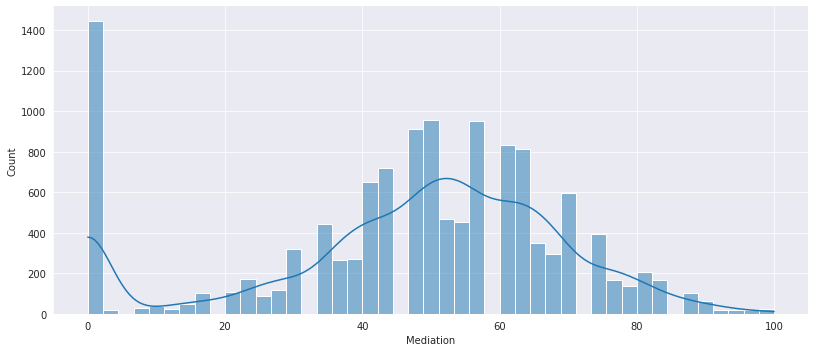

In [20]:
# Mediation stage of brain signal
sns.set_style('darkgrid')
sns.displot(data = input_df, x = 'Mediation', kde = True, aspect = 16/7)

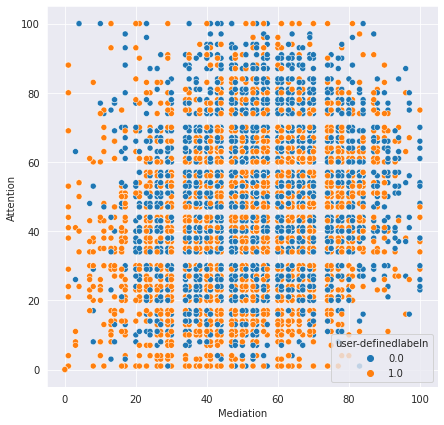

In [21]:
# plot scatter graph to see the trend of mediation and attention brainwave stage
# with user-definedlabel (confused or not)
fig, ax = plt.subplots(figsize = (7, 7))
sns.scatterplot(data = input_df, x = 'Mediation', y = 'Attention', hue = 'user-definedlabeln')

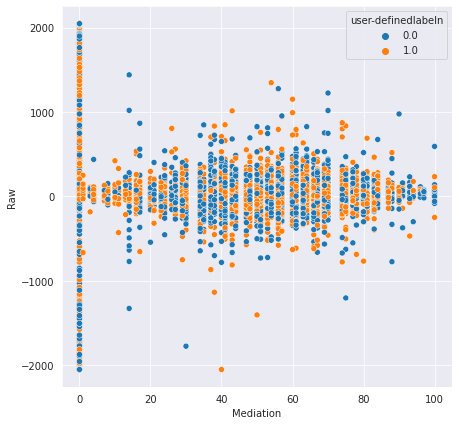

In [22]:
# plot scatter graph to see the trend of mediation brainwave stage
# with user-definedlabel (confused or not)
fig, ax=plt.subplots(figsize = (7, 7))
sns.scatterplot(data = input_df, x = 'Mediation', y = 'Raw', hue = 'user-definedlabeln')

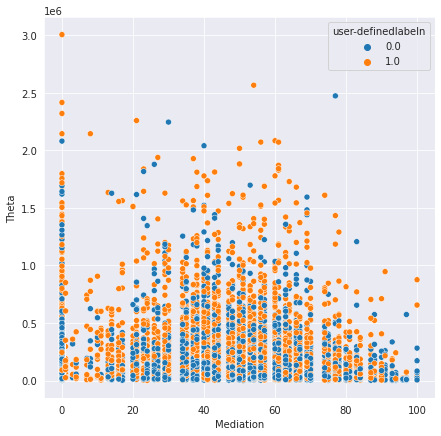

In [23]:
# plot scatter graph to see the trend of mediation brainwave stage, theta brainwave
# with user-definedlabel (confused or not)
fig, ax = plt.subplots(figsize = (7, 7))
sns.scatterplot(data = input_df, x = 'Mediation', y = 'Theta', hue = 'user-definedlabeln')

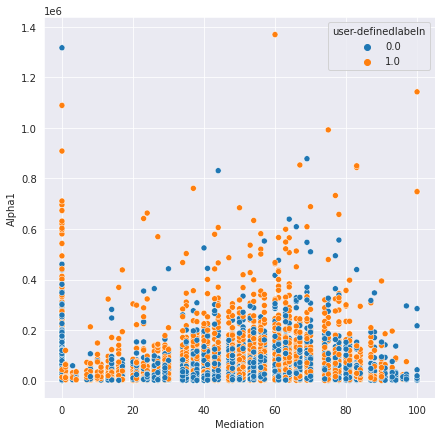

In [24]:
# plot scatter graph to see the trend of mediation brainwave stage, alpha1 brainwave
# with user-definedlabel (confused or not)
fig,ax=plt.subplots(figsize = (7, 7))
sns.scatterplot(data = input_df, x = 'Mediation', y = 'Alpha1', hue = 'user-definedlabeln')

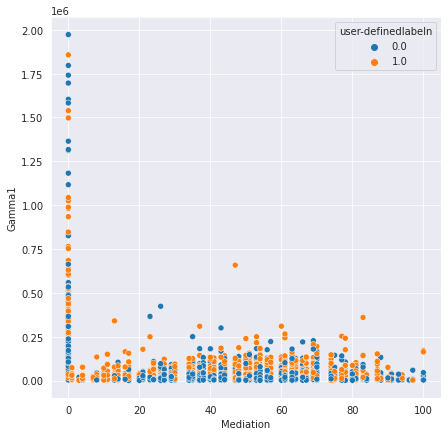

In [25]:
# plot scatter graph to see the trend of mediation brainwave stage, gamma1 brainwave
# with user-definedlabel (confused or not)
fig, ax = plt.subplots(figsize = (7, 7))
sns.scatterplot(data = input_df, x = 'Mediation', y = 'Gamma1' , hue = 'user-definedlabeln')

*From the visualization above, there's no direct relationship identified between features and target-variable*

## Feature-Selection

In [26]:
from sklearn.feature_selection import mutual_info_classif

In [32]:
# separating-out the feature-set and target-column
y = pd.get_dummies(input_df['user-definedlabeln'])

# mutual_info is used to get the score to each feature which describes its relationship with the target variable
mi_score = mutual_info_classif(input_df.drop('user-definedlabeln', axis = 1), input_df['user-definedlabeln'])
mi_score = pd.Series(mi_score, index = input_df.drop('user-definedlabeln', axis = 1).columns)
mi_score = (mi_score * 100).sort_values(ascending = False)
print(mi_score)

VideoID            6.464672
Alpha2             2.661867
Delta              2.404676
Gamma1             2.366238
Theta              2.137043
Beta1              2.063214
Alpha1             1.942042
Gamma2             1.736119
Attention          1.603060
Beta2              1.480130
SubjectID          1.213504
Mediation          0.653886
age                0.419023
predefinedlabel    0.153388
Raw                0.000000
ethnicity          0.000000
gender             0.000000
dtype: float64


In [33]:
# selecting only top 14 features from all 17 features
mi_score.head(14).index

Index(['VideoID', 'Alpha2', 'Delta', 'Gamma1', 'Theta', 'Beta1', 'Alpha1',
       'Gamma2', 'Attention', 'Beta2', 'SubjectID', 'Mediation', 'age',
       'predefinedlabel'],
      dtype='object')

In [34]:
top_features = ['VideoID', 'Attention', 'Alpha2', 'Delta', 'Gamma1', 'Theta', 'Beta1',
       'Alpha1', 'Mediation', 'Gamma2', 'SubjectID', 'Beta2', 'Raw', 'age']

In [36]:
# scaling our feature-set
from sklearn.preprocessing import StandardScaler
df_sc = StandardScaler().fit_transform(input_df[top_features])

## Build Neural-Network

In [37]:
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks,layers

### splitting the dataset into
1. training features/target
2. testing features/target
3. validation features/target

In [38]:
from sklearn.model_selection import train_test_split
X_train, x_test, Y_train, y_test = train_test_split(df_sc, y, random_state = 108, test_size = 0.27)
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, random_state = 108, test_size = 0.27)

### Building, compiling, and fitting the model

In [39]:
# Model-Building step, stacking the hidden layers
model = keras.Sequential([
    layers.Dense(64, input_shape = (14, ), activation = 'relu'), 
    layers.BatchNormalization(), 
    layers.Dropout(0.27), 
    layers.Dense(124, activation = 'relu'), 
    layers.BatchNormalization(), 
    layers.Dropout(0.3), 
    layers.Dense(248, activation = 'relu'), 
    layers.BatchNormalization(), 
    layers.Dropout(0.32),    
    layers.Dense(512, activation = 'relu'), 
    layers.BatchNormalization(), 
    layers.Dropout(0.27),    
    layers.Dense(664, activation = 'relu'), 
    layers.BatchNormalization(), 
    layers.Dropout(0.3), 
    layers.Dense(512, activation = 'relu'), 
    layers.BatchNormalization(), 
    layers.Dropout(0.32), 
    layers.Dense(264, activation = 'relu'), 
    layers.BatchNormalization(), 
    layers.Dropout(0.27), 
    layers.Dense(124, activation = 'relu'), 
    layers.BatchNormalization(), 
    layers.Dropout(0.3), 
    layers.Dense(2, activation = 'sigmoid')
])

# Compiling the model with Adamax Optimizer
model.compile(optimizer = 'adamax', loss = 'binary_crossentropy', metrics = 'accuracy')

In [40]:
# Creating the callback feature to stop the training in-Between,  in case of no improvement
call = callbacks.EarlyStopping(patience = 20, min_delta = 0.0001, restore_best_weights = True)
# Fitting the model
history = model.fit(x_train, y_train, validation_data = (x_val, y_val), batch_size = 28, epochs = 150, callbacks = [call])

Epoch 1/150
244/244 [==============================] - 9s 26ms/step - loss: 0.8630 - accuracy: 0.5234 - val_loss: 0.6653 - val_accuracy: 0.6219
Epoch 2/150
244/244 [==============================] - 6s 26ms/step - loss: 0.7788 - accuracy: 0.5640 - val_loss: 0.6536 - val_accuracy: 0.6279
Epoch 3/150
244/244 [==============================] - 6s 23ms/step - loss: 0.7346 - accuracy: 0.5787 - val_loss: 0.6304 - val_accuracy: 0.6623
Epoch 4/150
244/244 [==============================] - 6s 25ms/step - loss: 0.7145 - accuracy: 0.5911 - val_loss: 0.6170 - val_accuracy: 0.6655
Epoch 5/150
244/244 [==============================] - 6s 24ms/step - loss: 0.6943 - accuracy: 0.6040 - val_loss: 0.6121 - val_accuracy: 0.6726
Epoch 6/150
244/244 [==============================] - 5s 22ms/step - loss: 0.6759 - accuracy: 0.6181 - val_loss: 0.6019 - val_accuracy: 0.6829
Epoch 7/150
244/244 [==============================] - 4s 17ms/step - loss: 0.6648 - accuracy: 0.6242 - val_loss: 0.6020 - val_accuracy:

## Model evaluation

In [41]:
# evaluate loss and accuracy
model.evaluate(x_test, y_test)

109/109 [==============================] - 1s 5ms/step - loss: 0.1500 - accuracy: 0.9410


[0.1500277817249298, 0.9410234093666077]

#### Plotting the history of neural network

In [42]:
training = pd.DataFrame(history.history)

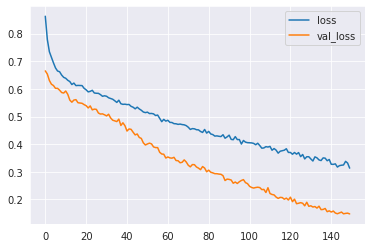

In [43]:
training.loc[:, ['loss', 'val_loss']].plot()

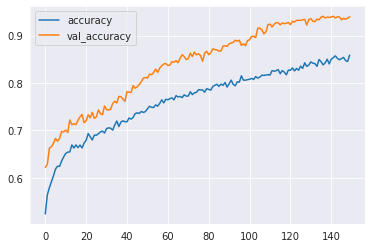

In [44]:
training.loc[:, ['accuracy', 'val_accuracy']].plot()

In [47]:
# Save the entire model as a SavedModel.
!mkdir -p saved-model
model.save('drive/MyDrive/Colab Notebooks/confused-eeg/saved_model/my_model')

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/confused-eeg/saved_model/my_model/assets


## Thanks
*Raksina Samasiri g6437977*